
## Active Learning Core Concepts

Active Learning vs. Passive Learning:**

Execute the following notebook cells:

-   look at the 2D PCA visualization of the [Forest
    Covertype](https://archive.ics.uci.edu/dataset/31/covertype) dataset
    (`sklearn.datasets.fetch_covtype`),
-   read the description of the dataset
    (<https://scikit-learn.org/stable/datasets/real_world.html#covtype-dataset>),
-   consider what the performance gap tells us about the opportunity of
    active learning for this dataset.

# Data Analysis and Understanding the Problem

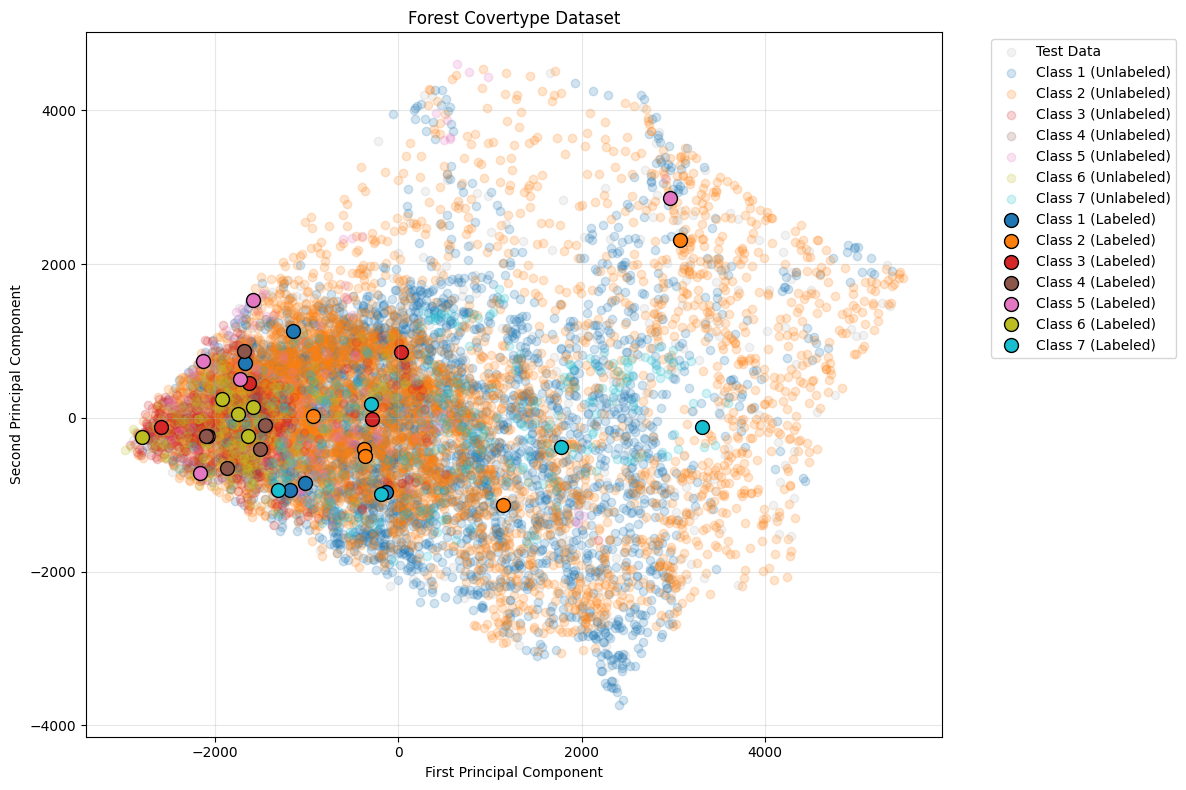

Total samples: 11000
Training samples: 10000
Test samples: 1000
Initially labeled samples: 35
Unlabeled pool size: 9965


In [ ]:
import numpy as np
from sklearn.conftest import fetch_covtype
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def create_al_synthetic_dataset(
    n_samples=10000,
    noise=0.3,
    random_state=42,
    n_samples_test=1000,
    labeled_samples = 5
):
    # Load the Forest Covertype dataset
    X, y = fetch_covtype(return_X_y=True )

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=n_samples,
        test_size=n_samples_test,
        random_state=random_state,
        stratify=y
    )

    # Select initial labeled points (5 from each class)
    train_idx = np.arange(len(y_train))
    class_indices = [train_idx[y_train == c] for c in np.unique(y_train)]

    np.random.seed(random_state + 3)
    labeled_idx = np.concatenate([
        np.random.choice(class_idx, labeled_samples, replace=False)
        for class_idx in class_indices
    ])
    unlabeled_idx = np.setdiff1d(train_idx, labeled_idx)

    return X_train, y_train, X_test, y_test, labeled_idx, unlabeled_idx

def visualize_dataset(
    X_train, y_train, labeled_idx, X_test=None, y_test=None, title="Forest Covertype Dataset"
):
    plt.figure(figsize=(12, 8))

    # Use PCA to reduce dimensionality for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_train_2d = pca.fit_transform(X_train)

    if X_test is not None:
        X_test_2d = pca.transform(X_test)
        # Plot test points if provided
        plt.scatter(
            X_test_2d[:, 0],
            X_test_2d[:, 1],
            c="gray",
            label="Test Data",
            alpha=0.1,
            zorder=-10,
        )

    # Get unique classes
    classes = np.unique(y_train)
    colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

    # Plot unlabeled training points
    for i, (c, color) in enumerate(zip(classes, colors)):
        mask = y_train == c
        plt.scatter(
            X_train_2d[mask][:, 0],
            X_train_2d[mask][:, 1],
            c=[color],
            label=f"Class {c} (Unlabeled)",
            alpha=0.2,
        )

    # Highlight labeled points
    for i, (c, color) in enumerate(zip(classes, colors)):
        mask = y_train[labeled_idx] == c
        # print(c)
        if np.any(mask):
            plt.scatter(
                X_train_2d[labeled_idx][mask][:, 0],
                X_train_2d[labeled_idx][mask][:, 1],
                c=[color],
                label=f"Class {c} (Labeled)",
                s=100,
                edgecolor="black",
            )

    plt.title(title)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


# Create and visualize the dataset
X_train, y_train, X_test, y_test, labeled_idx, unlabeled_idx = (
    create_al_synthetic_dataset()
)
visualize_dataset(X_train, y_train, labeled_idx, X_test, y_test)
plt.show()

# Print some statistics
print(f"Total samples: {len(X_train) + len(X_test)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Initially labeled samples: {len(labeled_idx)}")
print(f"Unlabeled pool size: {len(unlabeled_idx)}")

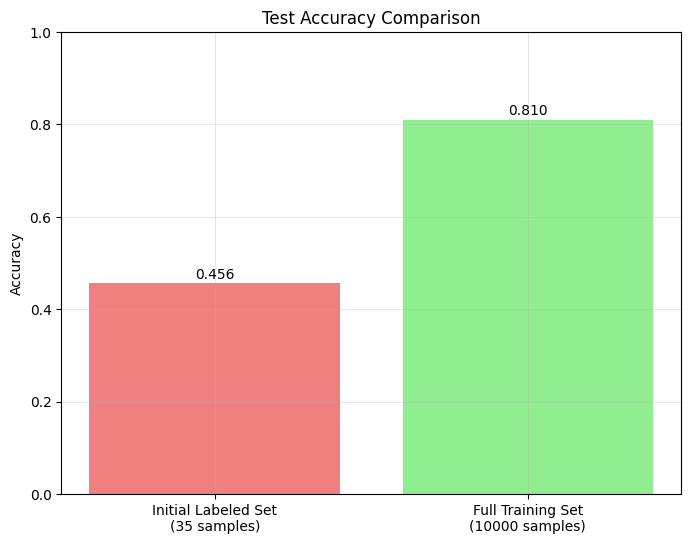

Performance gap: 0.354


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


def create_classifier(seed=42):
    return RandomForestClassifier(random_state=seed)


initial_classifier = create_classifier()
initial_classifier.fit(X_train[labeled_idx], y_train[labeled_idx])
initial_acc = accuracy_score(y_test, initial_classifier.predict(X_test))

full_classifier = create_classifier()
full_classifier.fit(X_train, y_train)
full_acc = accuracy_score(y_test, full_classifier.predict(X_test))

# Plot results
plt.figure(figsize=(8, 6))
accuracies = [initial_acc, full_acc]
plt.bar(
    [f"Initial Labeled Set\n({len(labeled_idx)} samples)", f"Full Training Set\n({len(y_train)} samples)"],
    accuracies,
    color=["lightcoral", "lightgreen"],
)
plt.ylim(0, 1)
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha="center")

plt.show()

print(f"Performance gap: {full_acc - initial_acc:.3f}")